In [1]:
import json
from PIL import Image
import matplotlib.pyplot as plt
import os
import shutil
import pandas as pd
import networkx as nx
import cv2

In [2]:
datasetRooot ='VG/'
datasetAttr = datasetRooot + 'Annotation/attributes.json'
datasetSG = datasetRooot + 'Annotation/scene_graphs.json'
datasetReSG = datasetRooot + 'Annotation/region_graphs.json'
datasetReDS = datasetRooot + 'Annotation/region_descriptions.json'
datasetSampleSG = datasetRooot + 'Annotation/sampleSG.json'
dataIm = datasetRooot + 'VG_100K/'
# dataExtractImSave = datasetRooot + 'ExtractDemo/ImageObj/'
# dataExtractAttrSave = datasetRooot + 'ExtractDemo/AttrObj/'

dataExtractImSave = datasetRooot + 'Extract/ImageObj/'
dataExtractAttrSave = datasetRooot + 'Extract/AttrObj/'
dataExtractRootImSave = datasetRooot + 'Extract/Img/'

In [7]:
reSG = json.load(open(datasetReSG))
len(reSG)

108077


In [3]:
with open(datasetRooot + "Annotation/sampleReSG.json", "w") as outfile:
    json.dump(reSG[0], outfile)

NameError: name 'reSG' is not defined

In [14]:
reDS = json.load(open(datasetReDS))
len(reDS)

108077

In [ ]:
with open(datasetRooot + "Annotation/sampleReDS.json", "w") as outfile:
    json.dump(reDS[0], outfile)

In [5]:
sg = json.load(open(datasetSG))
len(sg)

108077

In [27]:
def GetObjectNameSGOrg(objListJS, subjectId, objectId):
    subject = [item for item in objListJS if item['object_id'] == subjectId][0]
    object = [item for item in objListJS if item['object_id'] == objectId][0]

    nameSubject = subject['names'][0]
    nameObject = object['names'][0]
    #print(nameSubject, nameObject)
    return nameSubject, nameObject

def GetObjectNameSG(objListJS, subjectId, objectId):
    subject = [item for item in objListJS if item['object_id'] == subjectId][0]
    object = [item for item in objListJS if item['object_id'] == objectId][0]

    if('attributes' in subject.keys()):
        attr = str(subject['attributes']).replace("[","").replace("'","").replace("]"," ").replace(","," and ")
        names = subject['names'][0]
        nameSubject = attr + names
    else:
        names = subject['names'][0]
        nameSubject = names
    
    if('attributes' in object.keys()):
        attr = str(object['attributes']).replace("[","").replace("'","").replace("]"," ").replace(","," and ")
        names = object['names'][0]
        nameObject = attr + names
    else:
        names = object['names'][0]
        nameObject = names
    #print(nameSubject, nameObject)
    return nameSubject, nameObject


In [28]:
grphDF = []
for item in sg[:1]:
    objListJS = item['objects']
    for i, itemSg in enumerate(item['relationships'][:15], start=0):
        nameSubject, nameObject = GetObjectNameSGOrg(objListJS, itemSg['subject_id'], itemSg['object_id'])
        #print(nameSubject + " " + itemSg['predicate'] + " " + nameObject)
        lines = nameSubject + "-" + itemSg['predicate'] + "-" + nameObject
        grphDF .append(lines)
        #print(lines)

In [31]:
grphDFAttr = []
for item in sg[:1]:
    objListJS = item['objects']
    for i, itemSg in enumerate(item['relationships'][:15], start=0):
        nameSubject, nameObject = GetObjectNameSG(objListJS, itemSg['subject_id'], itemSg['object_id'])
        #print(nameSubject + " " + itemSg['predicate'] + " " + nameObject)
        lines = nameSubject + "-" + itemSg['predicate'] + "-" + nameObject
        grphDFAttr .append(lines)

In [29]:
src = [item.split('-')[0] for item in grphDF]
pre = [item.split('-')[1] for item in grphDF]
tar = [item.split('-')[-1] for item in grphDF]
kg_dfSG = pd.DataFrame({'source':src, 'target':tar, 'edge':pre})
kg_dfSG

,source,target,edge
0,shade,street,ON
1,man,sneakers,wears
2,car,headlight,has
3,sign,building,ON
4,tree trunk,sidewalk,ON
5,man,shirt,has
6,sidewalk,street,next to
7,car,back,has
8,man,glasses,has
9,parking meter,sidewalk,ON


In [33]:
srcAttr = [item.split('-')[0] for item in grphDFAttr]
preAttr = [item.split('-')[1] for item in grphDFAttr]
tarAttr = [item.split('-')[-1] for item in grphDFAttr]
kg_dfSGAttr = pd.DataFrame({'source':srcAttr, 'target':tarAttr, 'edge':preAttr})
kg_dfSGAttr

,source,target,edge
0,shade,sidewalk street,ON
1,man,grey sneakers,wears
2,car,off headlight,has
3,black sign,tall and brick and made of bricks building,ON
4,tree trunk,brick sidewalk,ON
5,man,red and orange shirt,has
6,brick sidewalk,clean street,next to
7,white and parked car,back,has
8,man,glasses,has
9,orange parking meter,brick sidewalk,ON


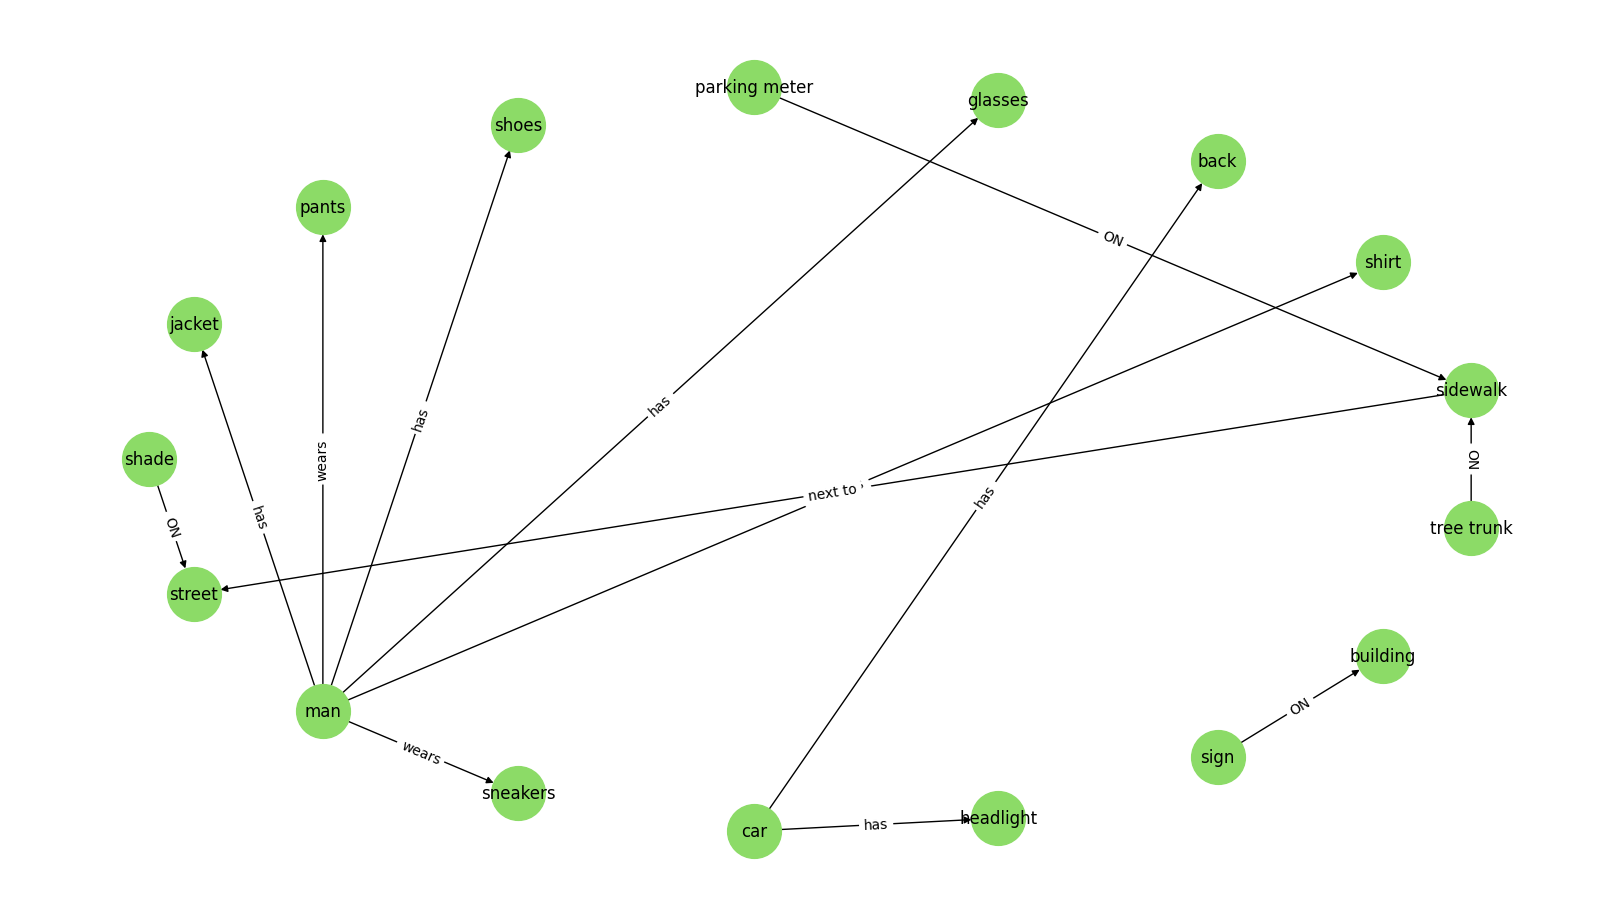

In [30]:
# create a directed-graph from a dataframe
SG=nx.from_pandas_edgelist(kg_dfSG, "source", "target", 
                          edge_attr=True, create_using=nx.DiGraph())

plt.figure(figsize=(16,9))

pos = nx.shell_layout(SG)
nx.draw(SG, with_labels=True, node_color='#8CDB67', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
edge_labels = nx.get_edge_attributes(SG, "edge")
nx.draw_networkx_edge_labels(SG, pos, edge_labels)
plt.show()

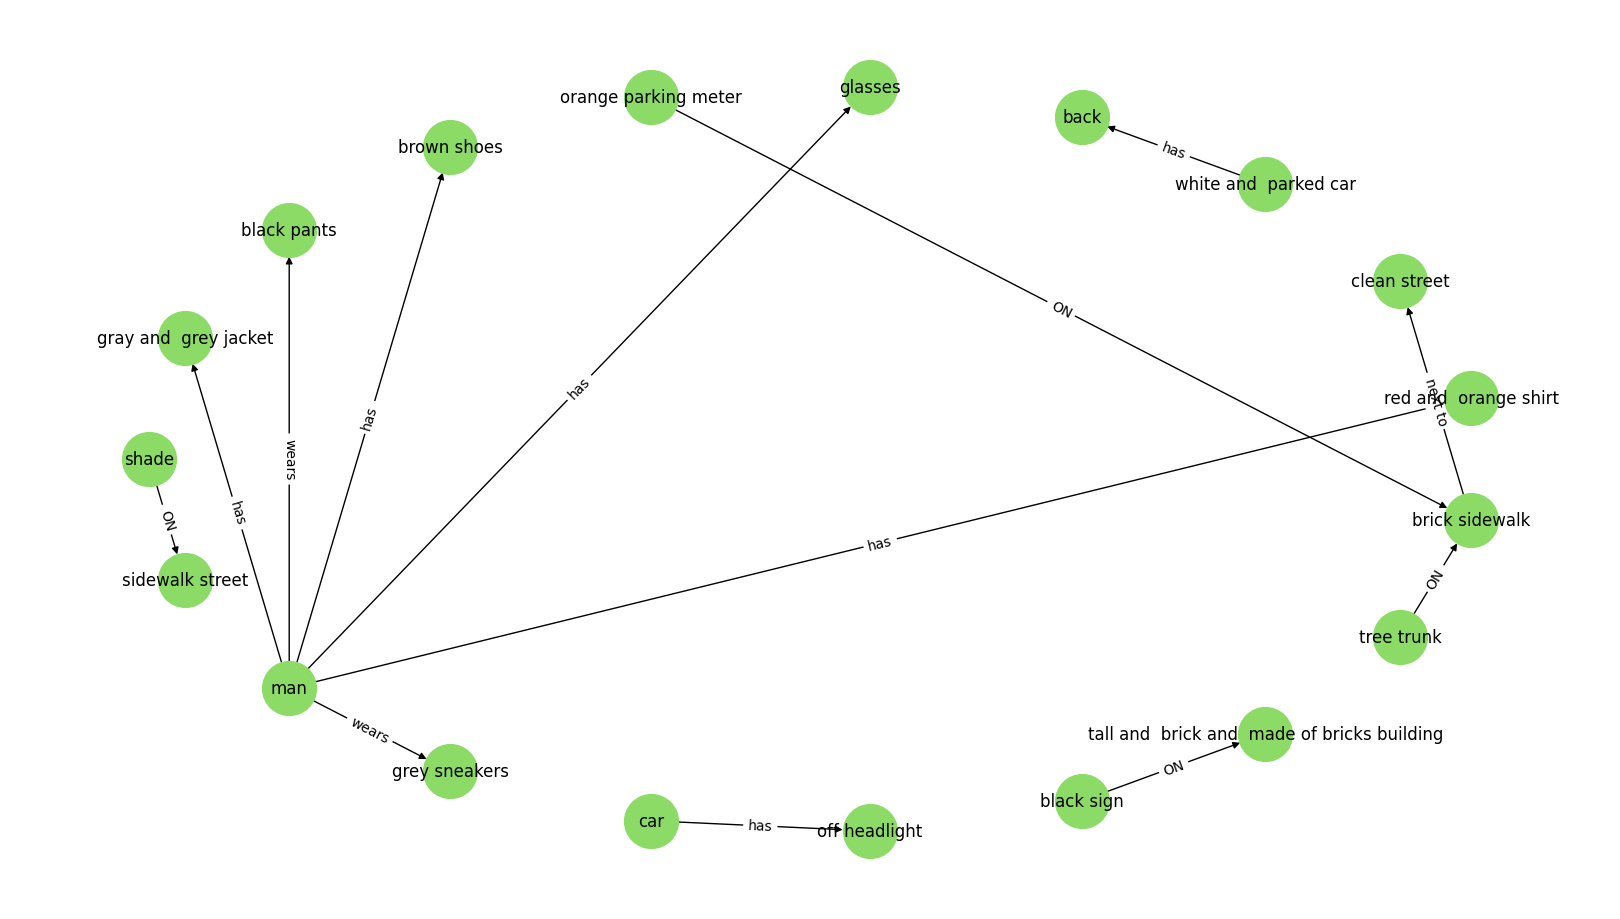

In [35]:
SGAttr=nx.from_pandas_edgelist(kg_dfSGAttr, "source", "target", 
                          edge_attr=True, create_using=nx.DiGraph())

plt.figure(figsize=(16,9))

pos = nx.shell_layout(SGAttr)
nx.draw(SGAttr, with_labels=True, node_color='#8CDB67', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
edge_labels = nx.get_edge_attributes(SGAttr, "edge")
nx.draw_networkx_edge_labels(SGAttr, pos, edge_labels)
plt.show()

In [3]:
sampleSG = json.load(open(datasetSG))
len(sampleSG)

108077

In [65]:
listObjects = sampleSG['objects']
listObjects[0]

TypeError: list indices must be integers or slices, not str

In [11]:
#image = Image.open(dataIm + str(sampleSG['image_id'])+'.jpg')
#image = cv2.imread(dataIm + str(sampleSG['image_id'])+'.jpg')
def GetBbox(objectId, listObjects):
    for item in listObjects:
        if(objectId == item['object_id']):
            x,y,w,h = item['x'], item['y'], item['w'], item['h']
            break
    return x,y,w,h
# for itemSG in sampleSG[:8000]:
#     shutil.copyfile(dataIm + '/'+ str(itemSG['image_id']) + '.jpg', 'VG/Extract/Images' +'/'+ str(itemSG['image_id']) + '.jpg')
#     with open(os.path.join("VG/Extract/BboxPairs", str(itemSG['image_id'])+'.txt'), 'w') as fw:
#         listObjects = itemSG['objects']
#         for item in itemSG['relationships'][:5]:
#             xS, yS, wS, hS = GetBbox(item['subject_id'], listObjects)
#             xO, yO, wO, hO = GetBbox(item['object_id'], listObjects)
#             # print('bbox subject: ', xS, yS, wS, hS)
#             # print('relationship_id: ', item['relationship_id'])
#             # print('bbox object: ', xO, yO, wO, hO)
#             # print(xS, yS, wS, hS, xO, yO, wO, hO)
#             #line = str(xS) + " " + str(yS) + " " + str(wS) + " " + str(hS) + " " + str(xO) + " " + str(yO) + " " + str(wO) + " " + str(hO) + "\n"
#             line = str(xS) + " " + str(yS) + " " + str(wS) + " " + str(hS) + " " + str(xO) + " " + str(yO) + " " + str(wO) + " " + str(hO)
#             fw.write(line)
#             # imgRec = cv2.rectangle(image, (xS, yS), (xS + wS, yS + hS), color=(0,0,255), thickness=2)
#             # imgRec = cv2.rectangle(imgRec, (xO, yO), (xO + wO, yO + hO), color=(255,0,0), thickness=2)
#             # plt.imshow(imgRec, cmap='gray')
#             # plt.show()
#             # print(item['subject_id'] , item['relationship_id'], item['object_id'])
#             # break
with open(os.path.join("VG/Extract/", 'Bbox.txt'), 'w') as fw:
    for itemSG in sampleSG[:8000]:
        lineBbox = ""
        shutil.copyfile(dataIm + '/'+ str(itemSG['image_id']) + '.jpg', 'VG/Extract/Images' +'/'+ str(itemSG['image_id']) + '.jpg')
        listObjects = itemSG['objects']
        if(len(itemSG['relationships'])>=5):
            for item in itemSG['relationships'][:5]:
                xS, yS, wS, hS = GetBbox(item['subject_id'], listObjects)
                xO, yO, wO, hO = GetBbox(item['object_id'], listObjects)
                lineBbox = lineBbox + str(xS) + " " + str(yS) + " " + str(wS) + " " + str(hS) + " " + str(xO) + " " + str(yO) + " " + str(wO) + " " + str(hO) + " "
            line = str(itemSG['image_id']) + '.jpg' + '#' + '0' + '\t' + lineBbox + '\n'
            fw.write(line)